# What is Pneumonia?

Pneumonia is a lung infection that inflames the alveoli, causing symptoms like cough (dry or productive), fever, chest pain, and breathing difficulties. It can range from mild to severe and is most commonly caused by bacteria or viruses, less often by other organisms, medications, or conditions like autoimmune diseases. Risk factors include COPD, asthma, diabetes, heart failure, smoking, stroke-related cough impairment, and weakened immunity. Diagnosis is based on symptoms, physical exam, chest X-ray, blood tests, and sometimes sputum culture. It’s classified by where it’s acquired—community, hospital, or healthcare-associated.

![Pneumonia Image](https://www.researchgate.net/publication/344488922/figure/fig1/AS:11431281256664885@1719559336841/The-lungs-and-chest-X-rays-showing-inflammation-leading-to-pneumonia-A-The-lung.jpg)

## Importing Libraries

In [1]:
# System and OS utilities
import os
import shutil
import random
import hashlib
from collections import defaultdict
from datetime import datetime
import traceback

# Data science and visualization
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Machine learning utilities
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# UI framework
import gradio as gr

# Google Colab-specific (if you actually need userdata, else remove)
from google.colab import userdata  # <-- Only if used explicitly in your notebook

## Importing Dataset

In [2]:
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

In [3]:
def download_and_extract_kaggle_dataset(dataset_name, output_dir):
    """Download and unzip Kaggle dataset into output_dir."""
    os.makedirs(output_dir, exist_ok=True)
    os.system(f"kaggle datasets download -d '{dataset_name}' -p {output_dir}")
    zip_files = [f for f in os.listdir(output_dir) if f.endswith(".zip")]
    for zip_file in zip_files:
        os.system(f"unzip -o {os.path.join(output_dir, zip_file)} -d {output_dir}")
        os.remove(os.path.join(output_dir, zip_file))

In [4]:
download_and_extract_kaggle_dataset("paultimothymooney/chest-xray-pneumonia", "./data")

In [5]:
download_and_extract_kaggle_dataset("nkifor/pneumonia-dataset", "./new_data")

## Data Organization

### CONFIG Dictionary
- Stores all configuration parameters for organizing datasets:

   - Paths to the two source datasets.

   - Output directory where organized images will be saved.

   - Limits on the number of images per split (train, val, test) to balance dataset sizes.

   - Random seed for reproducibility.

   - copy_only flag controls whether to copy or move files.

In [6]:
CONFIG = {
    "first_dataset": "./data/chest_xray",
    "second_dataset": "./new_data/xraychest",
    "output_dir": "./organized_data",
    "split_limits": {"train": 1000, "val": 300, "test": 145},
    "random_seed": 42,
    "copy_only": False
}

- Computes the SHA-256 hash of a file's binary content.

- Used to identify duplicate images reliably by content rather than filename.

- Returns None and prints a warning if hashing fails.

- Purpose: Prevents duplicate images from being added to the organized dataset.

In [7]:
def get_hash(filepath):
    try:
        with open(filepath, 'rb') as f:
            return hashlib.sha256(f.read()).hexdigest()
    except Exception as e:
        print(f"⚠️ Hash failed for {filepath}: {e}")
        return None

### Initialization Steps
- Sets a fixed random seed to ensure reproducible shuffling and splitting.

- Creates the output directory if it doesn’t exist.

- Loads hashes of already processed files in the output directory to avoid duplicates.

- Uses a defaultdict(int) called current_count to track how many images have been added per (split, class).

- **Purpose**: Prepares the environment and bookkeeping for dataset processing.

In [8]:
print("🚀 Initializing...")

random.seed(CONFIG["random_seed"])
os.makedirs(CONFIG["output_dir"], exist_ok=True)

# Track count per (split, class)
current_count = defaultdict(int)
seen_hashes = set()

# Load existing hashes to avoid duplicates
for root, _, files in os.walk(CONFIG["output_dir"]):
    for file in files:
        fpath = os.path.join(root, file)
        if os.path.isfile(fpath):
            h = get_hash(fpath)
            if h:
                seen_hashes.add(h)

🚀 Initializing...


### Processing the First Dataset

- Iterates over train, val, and test splits.

- Creates class subfolders: normal, bacterial_pneumonia, viral_pneumonia.

- Uses either shutil.copy or shutil.move based on copy_only.

- Adds images from NORMAL folder into normal class until split limit is reached.

- Adds images from PNEUMONIA folder, classifying them as bacterial or viral pneumonia based on filename content.

- Skips duplicate files by checking the hash.

- Skips files if split limits are reached.

- **Purpose**: Organizes and balances the first dataset with clear class and split separation.

In [9]:
print("📦 Processing first dataset...")

for split in ['train', 'val', 'test']:
    normal_src = os.path.join(CONFIG["first_dataset"], split, 'NORMAL')
    pneumo_src = os.path.join(CONFIG["first_dataset"], split, 'PNEUMONIA')
    dest_split = os.path.join(CONFIG["output_dir"], split)

    # Create class folders
    for cls in ['normal', 'bacterial_pneumonia', 'viral_pneumonia']:
        os.makedirs(os.path.join(dest_split, cls), exist_ok=True)

    op = shutil.copy if CONFIG["copy_only"] else shutil.move

    # Add NORMAL images
    if os.path.exists(normal_src):
        for fname in os.listdir(normal_src):
            src = os.path.join(normal_src, fname)
            if not os.path.isfile(src):
                continue
            h = get_hash(src)
            if h and h in seen_hashes:
                continue

            # Apply per-split cap
            if current_count[(split, 'normal')] >= CONFIG["split_limits"][split]:
                continue

            idx = current_count[(split, 'normal')] + 1
            ext = os.path.splitext(fname)[1]
            dst = os.path.join(dest_split, 'normal', f"normal_{idx:04d}{ext}")
            op(src, dst)
            seen_hashes.add(h)
            current_count[(split, 'normal')] += 1

    # Add PNEUMONIA images
    if os.path.exists(pneumo_src):
        for fname in os.listdir(pneumo_src):
            src = os.path.join(pneumo_src, fname)
            if not os.path.isfile(src):
                continue
            h = get_hash(src)
            if h and h in seen_hashes:
                continue

            if 'bacteria' in fname.lower():
                cls = 'bacterial_pneumonia'
            elif 'virus' in fname.lower():
                cls = 'viral_pneumonia'
            else:
                continue

            # Apply per-split cap
            if current_count[(split, cls)] >= CONFIG["split_limits"][split]:
                continue

            idx = current_count[(split, cls)] + 1
            ext = os.path.splitext(fname)[1]
            dst = os.path.join(dest_split, cls, f"{cls}_{idx:04d}{ext}")
            op(src, dst)
            seen_hashes.add(h)
            current_count[(split, cls)] += 1

    print(f"✅ {split} from first dataset processed.")

📦 Processing first dataset...
✅ train from first dataset processed.
✅ val from first dataset processed.
✅ test from first dataset processed.


### Processing the Second Dataset

- Builds a robust mapping from original folder names to standardized class names using case-insensitive checks.

- Collects file paths per new class.

- Randomly shuffles files within each class.

- Iterates through each file, tries to add it to splits in order train → val → test, respecting split limits.

- Skips duplicates and handles failures gracefully, trying next splits if needed.

- Stops adding files for a class once all splits reach their limits.

- **Purpose**: Integrates a second dataset into the organized structure while maintaining balance and avoiding duplicates.

In [10]:
print("📦 Processing second dataset...")

# ✅ Robust class mapping (case-insensitive)
class_mapping = {}
for folder in os.listdir(CONFIG["second_dataset"]):
    folder_path = os.path.join(CONFIG["second_dataset"], folder)
    if not os.path.isdir(folder_path):
        continue
    folder_lower = folder.lower()
    if 'normal' in folder_lower:
        class_mapping[folder] = 'normal'
    elif 'bacteria' in folder_lower or 'bacterial' in folder_lower:
        class_mapping[folder] = 'bacterial_pneumonia'
    elif 'virus' in folder_lower or 'viral' in folder_lower:
        class_mapping[folder] = 'viral_pneumonia'
    else:
        print(f"⚠️ Unknown folder (skipping): {folder}")

print(f"✅ Using class mapping: {class_mapping}")

# Collect and shuffle
second_files = defaultdict(list)
for old_class, new_class in class_mapping.items():
    old_path = os.path.join(CONFIG["second_dataset"], old_class)
    for fname in os.listdir(old_path):
        src = os.path.join(old_path, fname)
        if os.path.isfile(src):
            second_files[new_class].append(src)

for cls in second_files:
    random.shuffle(second_files[cls])

# Add files with per-split caps
for new_class, file_list in second_files.items():
    print(f"📌 Adding {new_class}...")

    for src_path in file_list:
        h = get_hash(src_path)
        if h and h in seen_hashes:
            continue

        added = False
        # Try train → val → test
        for split in ['train', 'val', 'test']:
            if current_count[(split, new_class)] >= CONFIG["split_limits"][split]:
                continue  # cap reached, skip to next split

            dest_dir = os.path.join(CONFIG["output_dir"], split, new_class)
            idx = current_count[(split, new_class)] + 1
            ext = os.path.splitext(src_path)[1]
            dst_path = os.path.join(dest_dir, f"{new_class}_{idx:04d}{ext}")

            op = shutil.copy if CONFIG["copy_only"] else shutil.move
            try:
                op(src_path, dst_path)
                seen_hashes.add(h)
                current_count[(split, new_class)] += 1
                print(f"✅ Added to {split}: {os.path.basename(dst_path)}")
                added = True
                break  # Move successful, skip remaining splits
            except Exception as e:
                print(f"❌ Move failed {src_path}: {e}")
                continue  # Try next split if this one fails

        if not added:
            # Check if all splits are full for this class
            all_full = all(
                current_count[(split, new_class)] >= CONFIG["split_limits"][split]
                for split in ['train', 'val', 'test']
            )
            if all_full:
                print(f"🛑 All splits full for {new_class}, stopping processing for this class")
                break  # Exit file_list loop for this class
            else:
                print(f"🚫 Skipped (all attempted splits full): {os.path.basename(src_path)}")

print("🏁 Finished processing second dataset")

📦 Processing second dataset...
✅ Using class mapping: {'Pneumonia_virus': 'viral_pneumonia', 'Normal': 'normal', 'Pneumonia_bacteria': 'bacterial_pneumonia'}
📌 Adding viral_pneumonia...
✅ Added to val: viral_pneumonia_0001.jpeg
✅ Added to val: viral_pneumonia_0002.jpeg
✅ Added to val: viral_pneumonia_0003.jpeg
✅ Added to val: viral_pneumonia_0004.jpeg
✅ Added to val: viral_pneumonia_0005.jpeg
✅ Added to val: viral_pneumonia_0006.jpeg
✅ Added to val: viral_pneumonia_0007.jpeg
✅ Added to val: viral_pneumonia_0008.jpeg
✅ Added to val: viral_pneumonia_0009.jpeg
✅ Added to val: viral_pneumonia_0010.jpeg
✅ Added to val: viral_pneumonia_0011.jpeg
✅ Added to val: viral_pneumonia_0012.jpeg
✅ Added to val: viral_pneumonia_0013.jpeg
✅ Added to val: viral_pneumonia_0014.jpeg
✅ Added to val: viral_pneumonia_0015.jpeg
✅ Added to val: viral_pneumonia_0016.jpeg
✅ Added to val: viral_pneumonia_0017.jpeg
✅ Added to val: viral_pneumonia_0018.jpeg
✅ Added to val: viral_pneumonia_0019.jpeg
✅ Added to val: 

### Final Counts and Visualization
- Counts the number of images in each class for each split.

- Prints totals per class and split.

- Plots a grouped bar chart showing final dataset balance.

- **Purpose**: Provides a summary and visual confirmation that the dataset is balanced as intended.

normal: 1445 total → train=1000, val=300, test=145
bacterial_pneumonia: 1445 total → train=1000, val=300, test=145
viral_pneumonia: 1445 total → train=1000, val=300, test=145


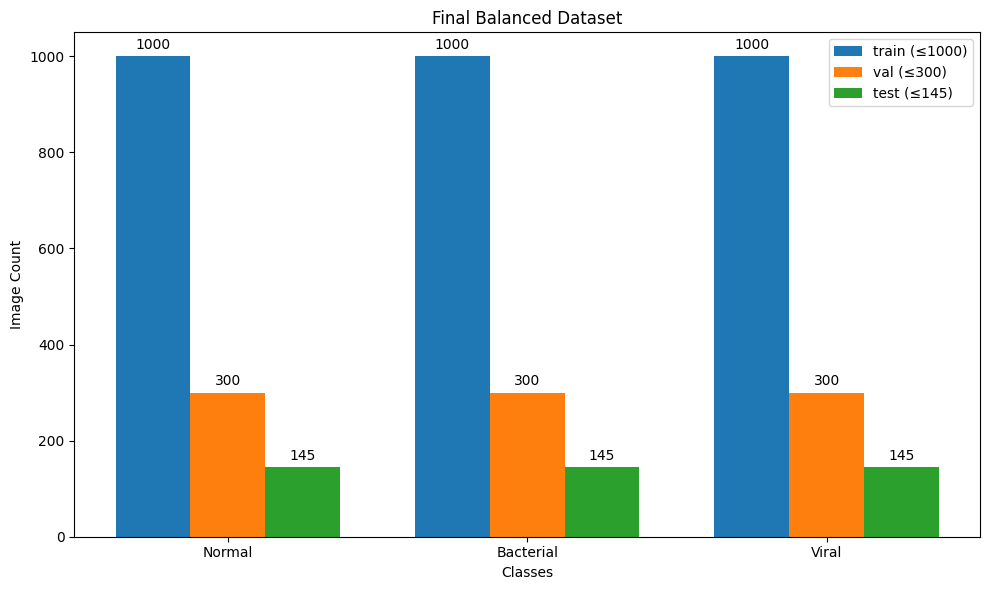

In [11]:
# Count final images
splits = ['train', 'val', 'test']
classes = ['normal', 'bacterial_pneumonia', 'viral_pneumonia']
final_counts = {s: {c: 0 for c in classes} for s in splits}

for split in splits:
    for cls in classes:
        path = os.path.join(CONFIG["output_dir"], split, cls)
        if os.path.exists(path):
            final_counts[split][cls] = len(os.listdir(path))

# Print totals
for cls in classes:
    total = sum(final_counts[s][cls] for s in splits)
    t, v, te = final_counts['train'][cls], final_counts['val'][cls], final_counts['test'][cls]
    print(f"{cls}: {total} total → train={t}, val={v}, test={te}")

# Plot
x = np.arange(len(classes))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))

for i, split in enumerate(splits):
    vals = [final_counts[split][cls] for cls in classes]
    ax.bar(x + i * width, vals, width, label = f"{split} (≤{CONFIG['split_limits'][split]})")

ax.set_xlabel('Classes')
ax.set_ylabel('Image Count')
ax.set_title('Final Balanced Dataset')
ax.set_xticks(x + width)
ax.set_xticklabels(['Normal', 'Bacterial', 'Viral'])
ax.legend()

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.tight_layout()
plt.show()

## Data Pre-processing

### Define Image loader and Pre-processer

#### **Constants:**


**IMG_SIZE = 224**

The target width and height of input images. Models like DenseNet expect a fixed input size, here 224×224 pixels.

---

**BATCH_SIZE = 32**

Number of images processed in one training step. A typical batch size balancing speed and memory.

In [12]:
IMG_SIZE = 224
BATCH_SIZE = 32

Creates a Keras ImageDataGenerator that:

- Loads images from a directory in batches.

- Rescales pixel values from [0,255] to [0,1] for normalization.

- Optionally applies data augmentation such as random rotation, width/height shifts, and horizontal flips to increase dataset diversity and reduce overfitting.

- Generates batches of images and their categorical labels, suitable for model training.

- **Usage**: Called for training, validation, and testing datasets to prepare data pipelines.

In [13]:
def create_data_generator(directory, target_size=(224,224), batch_size=32, augment=False):
    """Create an ImageDataGenerator with optional augmentation."""
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15 if augment else 0,
        width_shift_range=0.1 if augment else 0.0,
        height_shift_range=0.1 if augment else 0.0,
        horizontal_flip=augment
    )
    return datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

Enables augmentation for the training data to help the model generalize better.
Validation and test generators load data without augmentation to measure real performance.

In [15]:
train_generator = create_data_generator(CONFIG["output_dir"] + "/train", augment=True)
val_generator   = create_data_generator(CONFIG["output_dir"] + "/val")
test_generator  = create_data_generator(CONFIG["output_dir"] + "/test")

Found 3000 images belonging to 3 classes.
Found 900 images belonging to 3 classes.
Found 435 images belonging to 3 classes.


In [16]:
print("Classes:", train_generator.class_indices)

Classes: {'bacterial_pneumonia': 0, 'normal': 1, 'viral_pneumonia': 2}


## Model Building

Constructs and compiles the classification model:

- Uses DenseNet121 pretrained on ImageNet as the base feature extractor without the top classification layer (include_top=False).

- Applies Global Average Pooling to convert convolutional maps into a single vector per image.

- Adds a Dense layer with 256 units and ReLU activation for learning more complex patterns.

- Adds Dropout (0.5) to reduce overfitting by randomly disabling 50% of neurons during training.

- Adds Batch Normalization to stabilize and speed up training.

- Final Dense layer with num_classes units and softmax activation to output class probabilities.

- Compiles the model with Adam optimizer, categorical cross-entropy loss (suitable for multi-class classification), and accuracy metric.

- **Usage**: Called once to create a fresh model ready for training.

In [17]:
def build_model(num_classes):
    """Build and compile a DenseNet121-based classification model."""
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [18]:
model = build_model(train_generator.num_classes)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,301,699 (27.85 MB)

 Trainable params: 7,217,539 (27.53 MB)

 Non-trainable params: 84,160 (328.75 KB)

- Computes class weights inversely proportional to class frequencies to address class imbalance.

- Provides these weights during training so the model pays more attention to underrepresented classes.

- **Usage**: Improves training on imbalanced datasets by reducing bias towards dominant classes.

In [19]:
y_train = train_generator.classes
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in range(3)}
print("Class Weights:", class_weight_dict)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


## Model Training

**Callbacks**:

- EarlyStopping: Stops training if validation accuracy doesn’t improve for 3 epochs, restoring best weights.

- ReduceLROnPlateau: Reduces learning rate by half if validation accuracy plateaus for 2 epochs, helping fine-tune the model.

- ModelCheckpoint: Saves the best model based on highest validation accuracy during training.

- **Usage**: These callbacks help prevent overfitting, optimize learning, and save the best model automatically.

In [20]:
os.makedirs('saved_models', exist_ok=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2),
    tf.keras.callbacks.ModelCheckpoint(
        'saved_models/training/best_densenet_pneumonia.keras',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
]

- Trains the model for up to 20 epochs using the training data generator.

- Validates performance after each epoch using validation generator.

- Applies class weights to handle imbalanced classes.

- Uses the callbacks for early stopping, learning rate adjustment, and checkpointing.

- **Usage**: The core training loop that fits model parameters to the data.

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 821s 8s/step - accuracy: 0.4852 - loss: 3.3892 - precision: 0.5072 - recall: 0.4093 - val_accuracy: 0.6289 - val_loss: 2.8097 - val_precision: 0.6954 - val_recall: 0.5022 - learning_rate: 1.0000e-04
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 773s 8s/step - accuracy: 0.6668 - loss: 2.6918 - precision: 0.6919 - recall: 0.6272 - val_accuracy: 0.7144 - val_loss: 2.3882 - val_precision: 0.7604 - val_recall: 0.6489 - learning_rate: 1.0000e-04
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 800s 9s/step - accuracy: 0.6859 - loss: 2.4025 - precision: 0.7070 - recall: 0.6545 - val_accuracy: 0.7344 - val_loss: 2.1517 - val_precision: 0.7582 - val_recall: 0.6900 - learning_rate: 1.0000e-04
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 800s 9s/step - accuracy: 0.7225 - loss: 2.1763 - precision: 0.7435 - recall: 0.6968 - val_accuracy: 0.7389 - val_loss: 1.9773 - val_precision: 0.7572 - val_recall: 0.7033 - learning_rate: 1.0000e-04
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 779s 8s/step -

## Model Evaluation

### Load Model

In [ ]:
model = tf.keras.models.load_model('saved_models/training/best_densenet_pneumonia.keras')

11/14 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.8690 - loss: 1.0748 - precision: 0.9109 - recall: 0.8521

### Training History

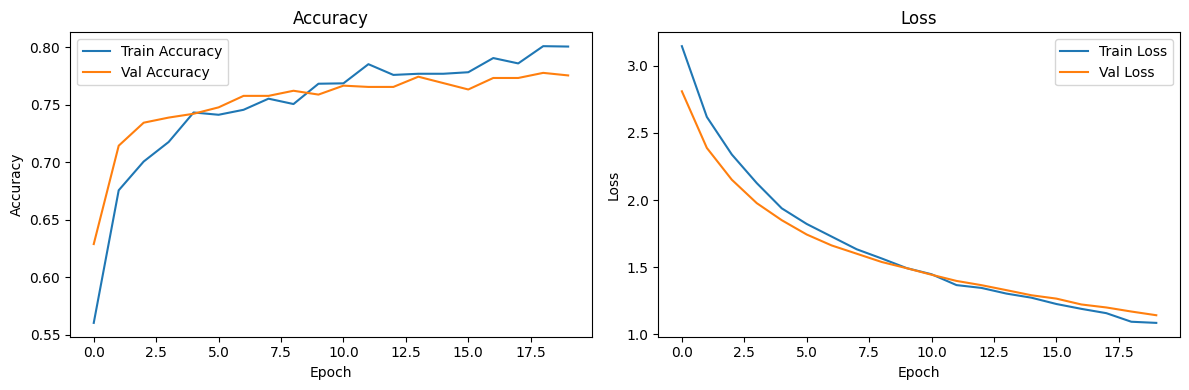

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.show()

### Confusion Matrix

14/14 ━━━━━━━━━━━━━━━━━━━━ 107s 7s/step


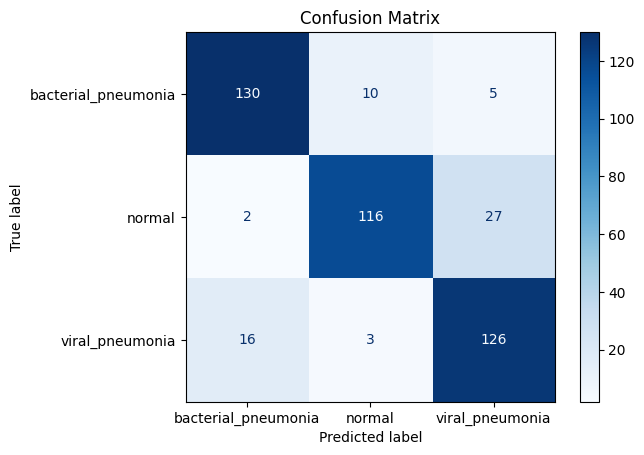

In [ ]:
# Predict
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

labels = list(train_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

### Metrics

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels))

                     precision    recall  f1-score   support

bacterial_pneumonia       0.88      0.90      0.89       145
             normal       0.90      0.80      0.85       145
    viral_pneumonia       0.80      0.87      0.83       145

           accuracy                           0.86       435
          macro avg       0.86      0.86      0.86       435
       weighted avg       0.86      0.86      0.86       435



## Save Model

In [ ]:
model.save('saved_models/chest_x_ray_pneumonia_detector.keras')

## User Interface - The place where Doctors interact with the Model

### Constants and Setup
- **MODEL_PATH**: Path to the saved Keras model file.

- **LABELS**: List of classification categories — here, ["Bacterial", "Normal", "Viral"].

- **LABELED_DATA_DIR**: Directory where labeled images will be stored.

- **TARGET_SIZE**: The target input size for images (224x224 pixels), matching the model's expected input dimensions.

In [21]:
MODEL_PATH = "saved_models/training/best_densenet_pneumonia.keras"
LABELS = ["Bacterial", "Normal", "Viral"]
LABELED_DATA_DIR = "labeled_data"
TARGET_SIZE = (224, 224)

Creates the necessary folder structure for storing labeled images.

- Ensures the base directory exists.

- Creates one subdirectory per label.

- **Usage**: Call once before saving feedback images to organize data.

In [22]:
def ensure_label_directories(base_dir=LABELED_DATA_DIR, labels=LABELS):
    os.makedirs(base_dir, exist_ok=True)
    for label in labels:
        os.makedirs(os.path.join(base_dir, label), exist_ok=True)

In [23]:
ensure_label_directories()

Loads the trained Keras model from disk with error handling.

- Checks if the model file exists, raises FileNotFoundError if missing.

- Tries to load the model and prints success or failure messages.

- **Usage**: Call once at the start to load your classification model safely.

In [24]:
def load_model_with_checks(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at {model_path}")
    try:
        model = tf.keras.models.load_model(model_path)
        print("✅ Model loaded successfully!")
        return model
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        raise

In [26]:
try:
    model = load_model_with_checks(MODEL_PATH)
except:
    model = None

✅ Model loaded successfully!


Prepares a sub-model for Grad-CAM visualization.

- Returns a model outputting two things:

  - The convolutional feature maps from a specified layer (or auto-detected last conv layer).

  - The final prediction output.

- Checks the chosen layer is suitable (4D tensor, typically a conv layer).

- **Usage**: Used internally in Grad-CAM computation to extract intermediate activations.

In [27]:
# Cache for gradcam submodels to avoid rebuilding each time
_gradcam_submodel_cache = {}

In [28]:
def get_gradcam_model(model, layer_name=None):
    """Return a model for Grad-CAM that outputs (conv_features, predictions)."""
    if layer_name:
        try:
            layer = model.get_layer(layer_name)
            if len(layer.output.shape) != 4:
                raise ValueError(f"Layer '{layer_name}' is not 4D. Pick a convolutional feature map.")
            return tf.keras.models.Model(inputs=model.inputs, outputs=[layer.output, model.output])
        except Exception as e:
            print(f"⚠️ Could not use specified layer '{layer_name}': {e}")

    # Auto-detect last conv layer (must be 4D output)
    for layer in reversed(model.layers):
        if len(layer.output.shape) == 4 and 'conv' in layer.name:
            print(f"ℹ️ Using fallback layer for Grad-CAM: {layer.name}")
            return tf.keras.models.Model(inputs=model.inputs, outputs=[layer.output, model.output])

    raise ValueError("No suitable convolutional layer found for Grad-CAM.")

Prepares an input image for the model:

- Accepts PIL Image or NumPy array.

- Converts and resizes the image to the target size.

- Applies model-specific preprocessing (DenseNet preprocessing here).

- Returns a preprocessed NumPy array ready for prediction and the resized PIL image.

- **Usage**: Called before feeding images into the model for prediction or Grad-CAM.

In [29]:
def process_image_for_model(img, target_size=TARGET_SIZE):
    """Return (preprocessed_array, original_pil).
       Accepts PIL.Image or numpy array from Gradio (type='numpy')."""
    if img is None:
        raise ValueError("No image provided to preprocess.")
    if isinstance(img, np.ndarray):
        pil = Image.fromarray(img)
    elif isinstance(img, Image.Image):
        pil = img
    else:
        raise ValueError(f"Unsupported image type: {type(img)}")

    pil_resized = pil.convert("RGB").resize(target_size, Image.BILINEAR)
    arr = np.array(pil_resized).astype(np.float32)
    arr = np.expand_dims(arr, axis=0)  # (1, H, W, 3)
    # Use the same preprocess that the model expects (DenseNet here)
    arr = tf.keras.applications.densenet.preprocess_input(arr)
    return arr, pil_resized

Generates the Grad-CAM heatmap for an input image tensor.

- Uses get_gradcam_model to get conv feature maps and predictions.

- Computes gradients of the predicted class score with respect to conv features.

- Aggregates gradients spatially to weigh feature maps.

- Produces a normalized heatmap showing important regions.

- **Usage**: Visual explanation of what regions the model focused on when making its prediction.

In [30]:
def make_gradcam_heatmap(img_array, model, pred_index=None, last_conv_layer_name=None):
    grad_model = get_gradcam_model(model, last_conv_layer_name)

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        tape.watch(conv_outputs)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)[0]  # shape: (H, W, C)
    if grads.ndim != 3:
        raise ValueError(f"Expected 3D grads (H, W, C) but got shape {grads.shape}")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-7
    return heatmap.numpy()

Creates a visualization by overlaying the Grad-CAM heatmap onto the original image.

- Converts grayscale images to RGB if necessary.

- Resizes the heatmap to the image size.

- Applies a colormap (JET) to the heatmap for color visualization.

- Blends the heatmap with the original image using transparency alpha.

- **Usage**: To produce the final user-friendly visualization of model attention.

In [31]:
def generate_heatmap_overlay(img, heatmap, alpha=0.4, target_size=None):
    img_array = np.array(img)
    if img_array.ndim == 2:
        img_array = np.stack((img_array,) * 3, axis=-1)

    # Resize heatmap to target_size if provided, else use img size
    if target_size is None:
        target_size = (img_array.shape[1], img_array.shape[0])  # (width, height)

    heatmap_resized = cv2.resize(heatmap, target_size, interpolation=cv2.INTER_LINEAR)
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    return cv2.addWeighted(img_array, 1 - alpha, heatmap_colored, alpha, 0)

Runs the full prediction pipeline end-to-end:

- Processes the image for the model.

- Gets prediction probabilities.

- Finds the predicted class label and confidence.

- Generates the Grad-CAM heatmap.

- Returns a dictionary with label, confidence, heatmap, original PIL, all predictions, and preprocessed array.

- **Usage**: Main function to get both prediction and explanation from an input image.

In [32]:
def predict_on_image(image, model, labels=LABELS, gradcam_layer_name=None):
    """End-to-end prediction returning label, confidence, heatmap and original PIL."""
    if model is None:
        raise RuntimeError("Model is not loaded.")
    preproc, original_pil = process_image_for_model(image)
    preds = model.predict(preproc, verbose=0)[0]
    pred_idx = int(np.argmax(preds))
    pred_label = labels[pred_idx]
    confidence = float(preds[pred_idx])
    heatmap = make_gradcam_heatmap(preproc, model, pred_idx, last_conv_layer_name=gradcam_layer_name)
    return {
        "label": pred_label,
        "confidence": confidence,
        "heatmap": heatmap,
        "original_pil": original_pil,
        "all_predictions": preds,
        "preprocessed_array": preproc
    }

Visualizes the original image, the heatmap, and the overlay side-by-side using matplotlib.

- Useful for debugging or displaying results in notebooks.

- Shows original X-ray, attention map, and Grad-CAM overlay with optional labels.

- **Usage**: For visual analysis and presentations.

In [33]:
def plot_gradcam(original_pil, heatmap, true_label=None, predicted_label=None):
    superimposed = generate_heatmap_overlay(original_pil, heatmap, alpha=0.4, target_size=(724, 824))
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_pil)
    plt.title("Original X-ray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap="viridis")
    plt.title("Attention map")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    title = "Grad-CAM"
    if true_label:
        title += f"\nTrue: {true_label}"
    if predicted_label:
        title += f"\nPred: {predicted_label}"
    plt.imshow(superimposed)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Handles a user-provided image to produce prediction and visualization.

- Checks model and input validity.

- Calls predict_on_image.

- Generates overlay image for UI display.

- Formats result text.

- Controls UI visibility for feedback.

- **Usage**: Connected to the frontend/UI to process an uploaded image and show results.

In [34]:
def predict_and_feedback(xray_image):
    if xray_image is None:
        return None, "❌ Please upload an image.", gr.update(visible=False), gr.update(visible=False), "", ""

    if model is None:
        return None, "❌ Model not loaded. Contact admin.", gr.update(visible=False), gr.update(visible=False), "", ""

    try:
        result = predict_on_image(
            xray_image,
            model,
            gradcam_layer_name="conv5_block16_concat"
        )
        pred_label = result["label"]
        confidence = result["confidence"]
        heatmap = result["heatmap"]
        original_pil = result["original_pil"]

        # Resize original image to target display size
        display_size = (724, 824)  # (width, height)
        original_resized = original_pil.resize(display_size)

        # Generate heatmap overlay - pass display size explicitly to resize heatmap properly
        superimposed_pil = generate_heatmap_overlay(original_resized, heatmap, alpha=0.4, target_size=display_size)

        result_text = f"### 🧠 Predicted: **{pred_label}**\n\n**Confidence:** `{confidence:.2f}`"

        return (
            superimposed_pil,
            result_text,
            gr.update(visible=True),
            gr.update(visible=False),
            "",
            pred_label
        )

    except Exception as e:
        traceback.print_exc()
        return None, f"❌ Error during prediction: {e}", gr.update(visible=False), gr.update(visible=False), "", ""

Processes user feedback to save correctly or incorrectly labeled images for future retraining.

- Decides which label to save based on correctness feedback.

- Saves the image into the appropriate folder with a timestamp.

- Updates feedback UI with success or error messages.

- **Usage**: Used to collect human feedback and expand labeled dataset.

In [35]:
def on_feedback(correct, correct_label, input_image_array, predicted_label):
    # input_image_array will be the numpy array Gradio provides from the upload
    if input_image_array is None:
        return gr.update(value="⚠️ No image to save.", visible=True)

    label_to_save = predicted_label if correct == "Yes" else correct_label
    if not label_to_save or label_to_save not in LABELS:
        return gr.update(value=f"⚠️ Invalid label: '{label_to_save}'", visible=True)

    try:
        ensure_label_directories()  # uses defaults
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"{label_to_save}_{timestamp}.jpg"
        save_path = os.path.join(LABELED_DATA_DIR, label_to_save, filename)

        # Convert numpy array to PIL and save
        if isinstance(input_image_array, np.ndarray):
            img_to_save = Image.fromarray(input_image_array)
        else:
            img_to_save = input_image_array  # hope it's PIL

        img_to_save.save(save_path, quality=95)
        return gr.update(value=f"✅ Saved: `{save_path}`", visible=True)
    except Exception as e:
        traceback.print_exc()
        return gr.update(value=f"❌ Save failed: {e}", visible=True)

In [36]:
with gr.Blocks(title="🩺 X-Ray AI Assistant") as demo:
    gr.Markdown("# 🩺 Chest X-Ray AI Diagnosis Assistant")
    gr.Markdown(
        "Upload a chest X-ray image. The AI will predict whether it shows signs of **Bacterial**, **Viral**, or **Normal** condition, "
        "and highlight the areas it focused on using **Grad-CAM**. Help improve the model by providing feedback!"
    )

    with gr.Row():
        with gr.Column():
            xray_input = gr.Image(label="📤 Upload X-Ray Image", type="numpy")
            submit_btn = gr.Button("🔍 Analyze X-Ray", variant="primary")

        with gr.Column():
            output_image = gr.Image(label="🧠 AI Attention Map (Grad-CAM)", type="pil", height=824, width=724)
            output_text = gr.Markdown("Prediction will appear here...")

    # Feedback Section (Initially Hidden)
    with gr.Row(visible=False) as feedback_row:
        gr.Markdown("### 📝 Provide Feedback")
        correct = gr.Radio(["Yes", "No"], label="✅ Was the prediction correct?", value=None)

        correct_label = gr.Dropdown(
            choices=LABELS,
            label="❌ If incorrect, select the correct label:",
            visible=False
        )

        submit_feedback = gr.Button("📤 Submit Feedback")

        # Toggle dropdown visibility
        def toggle_label(choice):
            return gr.update(visible=(choice == "No"))

        correct.change(fn=toggle_label, inputs=correct, outputs=correct_label)

    feedback_status = gr.Textbox(label="Feedback Result", visible=False)
    predicted_label_box = gr.Textbox(visible=False)

    submit_btn.click(
        fn=predict_and_feedback,
        inputs=xray_input,
        outputs=[output_image, output_text, feedback_row, correct_label, feedback_status, predicted_label_box]
    )

    submit_feedback.click(
        fn=on_feedback,
        inputs=[correct, correct_label, xray_input, predicted_label_box],
        outputs=feedback_status
    )

### Start Web Server

In [37]:
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fb1e1677ce6058e361.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Close Web Server

In [38]:
demo.close()

Closing server running on port: 7860
